# Visualizations in CNN with Flower Recognition dataset (tf_flowers dataset from tensorflow hub)

**This notebook aims to visualize intermediary outputs of Convolutional Neural Network to help in debugging<br> Areas of Improvement - Improve model accuracy by tuning various hyper-parameters or using transfer learning**

In [1]:
#All imports

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

**Download the 'tf_flowers' dataset from tensorflow hub. This has images of flowers belonging to 5 categories**

In [3]:
#As only training data is available, so splitting the same to form train and validation
(training_set, validation_set), metadata = tfds.load('tf_flowers', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
#details of dataset
print(metadata)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [5]:
print ("# of training samples: ", len(training_set))
print ("# of validation samples: ", len(validation_set))

num_classes = metadata.features['label'].num_classes
classes = metadata.features['label'].names
print ("# of categories: ", num_classes)
print ('categories: ', classes)

# of training samples:  2936
# of validation samples:  734
# of categories:  5
categories:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


**Preprocessing**

Image size:  (333, 500, 3)


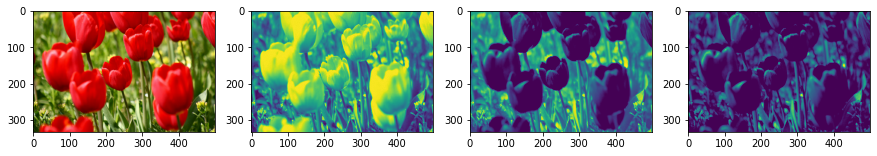

In [6]:
#Display channels of first image from training dataset
for elem in training_set.take(1):
  image = elem[0] 
  print ("Image size: ", elem[0].shape)
  f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)  
  f.set_figwidth(15)
  ax1.imshow(image)
  ax2.imshow(image[:,:,0])
  ax3.imshow(image[:,:,1])
  ax4.imshow(image[:,:,2])

In [7]:
#Define processing batch size and target image size as images in training set are of different sizes
batch_sz=100
image_shape = 224

training_data = training_set.map(lambda x,y : (tf.keras.preprocessing.image.smart_resize(x, size=(image_shape, image_shape)), y))
validation_data = validation_set.map(lambda x,y : (tf.keras.preprocessing.image.smart_resize(x, size=(image_shape, image_shape)), y))

In [8]:
#Define features and labels as 4d numpy array suitable to be fed to ImageDataGenerator
training_features = training_data.map(lambda x,y :x)
training_features = np.stack(list(x.numpy() for x in training_features), axis=0)

training_labels = training_data.map(lambda x,y :y)
training_labels = np.stack(list(y.numpy() for y in training_labels), axis=0)

validation_features = validation_data.map(lambda x,y :x)
validation_features = np.stack(list(x.numpy() for x in validation_features), axis=0)

validation_labels = validation_data.map(lambda x,y :y)
validation_labels = np.stack(list(y.numpy() for y in validation_labels), axis=0)

#Convert labels to categorical 
y_train = tf.keras.utils.to_categorical(training_labels, num_classes)
y_val = tf.keras.utils.to_categorical(validation_labels, num_classes)

In [9]:
#Using tensorflow ImageDataGenerator to perform data augmentation and rescaling on training data
image_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                    horizontal_flip=True,
                    vertical_flip=True,
                    rescale = 1./255,
                    rotation_range=45,
                    zoom_range=0.5,
                    width_shift_range=.15,
                    height_shift_range=.15,
                  )

image_data_gen.fit(training_features)

#DataGenerator with rescaling for validation data
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)                                                               

**A basic CNN model architecture**

In [10]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(image_shape,image_shape, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

#A checkpoint callback to save best performing model obtained on validation data with given number of iterations
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)

In [11]:
#training the model
model.fit(image_data_gen.flow(training_features, y_train, batch_size=batch_sz, shuffle=True),
          epochs=100, 
          steps_per_epoch=np.ceil(len(training_features) / float(batch_sz)),
          validation_data = val_data_gen.flow(validation_features, y_val, batch_size=batch_sz),
          validation_steps = np.ceil(len(validation_features) / float(batch_sz)),
          callbacks=[model_checkpoint]
          )

Epoch 1/100
30/30 [==============================] - 39s 1s/step - loss: 2.4088 - accuracy: 0.2540 - val_loss: 1.3230 - val_accuracy: 0.3992
Epoch 2/100
30/30 [==============================] - 33s 1s/step - loss: 1.2868 - accuracy: 0.4337 - val_loss: 1.1788 - val_accuracy: 0.4959
Epoch 3/100
30/30 [==============================] - 33s 1s/step - loss: 1.1425 - accuracy: 0.5169 - val_loss: 1.0143 - val_accuracy: 0.6008
Epoch 4/100
30/30 [==============================] - 33s 1s/step - loss: 1.0477 - accuracy: 0.5672 - val_loss: 1.0436 - val_accuracy: 0.5763
Epoch 5/100
30/30 [==============================] - 33s 1s/step - loss: 1.0379 - accuracy: 0.5807 - val_loss: 0.9407 - val_accuracy: 0.6322
Epoch 6/100
30/30 [==============================] - 33s 1s/step - loss: 0.9662 - accuracy: 0.6216 - val_loss: 0.9057 - val_accuracy: 0.6444
Epoch 7/100
30/30 [==============================] - 33s 1s/step - loss: 0.9134 - accuracy: 0.6398 - val_loss: 0.8657 - val_accuracy: 0.6471
Epoch 8/100
3

**Load the saved model in case to be used later**

In [12]:
reloaded = tf.keras.models.load_model('best_model.h5')
reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

**Visualize filters of convolutional layer**

In [15]:
#custom function to get filters of a particular layer
def get_filters(model, layer_num):
  filters, weights = model.layers[layer_num].get_weights()
  return filters

#custom function to plot the filters
def plot_filters(filters, filters_count):
  plt.figure(figsize=(6,8))  
  n_channels = filters.shape[2]
  ix = 1
  for n_filter in range(filters_count-1):
    f = filters[:,:,:,n_filter]
    for i in range(n_channels):
      ax = plt.subplot(filters_count, n_channels, ix)  
      ax.set_xticks([])
      ax.set_yticks([])    
      plt.imshow(f[:,:,i])
      ix += 1
  plt.show()

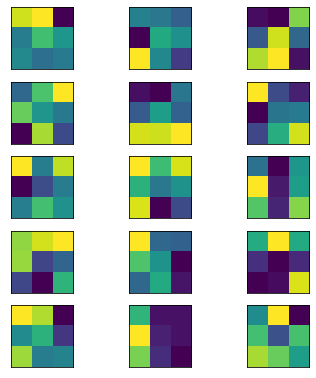

In [16]:
#plot first six filters of first convolutional layer
filters = get_filters(reloaded, 0)
plot_filters(filters, 6)

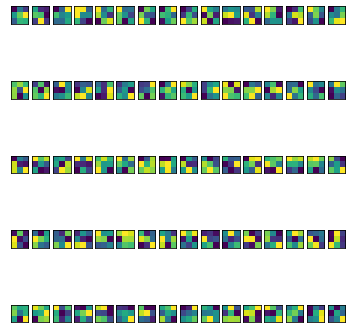

In [17]:
#plot first six filters of second convolutional layer
filters = get_filters(reloaded, 2)
plot_filters(filters, 6)  

**Based on above plots, filters of first few layers focus on raw features like edge detection**

**Visualize feature maps or activations or output of Convolution layer**

In [18]:
#Define a model explicitly specifying the output to be the output of convolution layer to be visualized
#Here visualizing the output of first pooling layer
custom_model = tf.keras.models.Model(inputs=reloaded.inputs, outputs = reloaded.layers[1].output)
custom_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


**Load the test image whose activations needs to be visualized**

In [19]:
test_img = tf.keras.preprocessing.image.load_img('test_img.jpg', 
                                                 target_size=(image_shape, image_shape))
test_img_arr = tf.keras.preprocessing.image.img_to_array(test_img)
test_img_arr = tf.expand_dims(test_img_arr, axis=0)
test_img_arr = test_img_arr / 255

In [20]:
test_prediction = custom_model.predict(test_img_arr)

**Visualize activations of the test image**

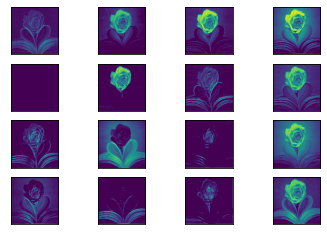

In [21]:
#16 features to be visualized, so splitting 4 in each row 
#plt.figure(figsize=(10,20))
for i in range(0,16,4):  
  for j in range(4):
    feature_map = test_prediction[:,:,:,i+j]
    plt.subplot(4,4,i+j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_map[0,:,:])
plt.show()

**Visualize Gradient Class Activation Map to determine the portion of the image that contributed in classifying the specific label to the test image**

In [22]:
#Determine the last convolution/pooling layer
last_cnn_layer = ''
for layer in reversed(reloaded.layers):
  if len(layer.output_shape) == 4:
    last_cnn_layer = layer.name
    break

#define a model instance to extract the output of last CNN block with test image as input
grad_model = tf.keras.models.Model(inputs=[reloaded.inputs], outputs=[reloaded.get_layer(last_cnn_layer).output, reloaded.output])

#record the computations on tape to be used to compute gradient.
# This is termed as automatic differentiation i.e a value is computed first and then its derivatives
with tf.GradientTape() as tape:
  (conv_outputs, predictions) = grad_model(test_img_arr)  
  loss = predictions[:,4]

predicted_label = np.argmax(predictions)
print("Test image predicted as: ", classes[predicted_label])

#find the gradient of the output label 4(Rose) with respect to the output(activation maps) of last convolutional block. 
#This is to determine contribution of last activation map or specifically contribution of each channel of last output towards target label
grads = tape.gradient(loss, conv_outputs)
guided_grads = conv_outputs * grads

Test image predicted as:  roses


In [23]:
#Excluding the batch dimension of convolutional output and guided gradients
conv_outputs = conv_outputs[0]
guided_grads = guided_grads[0]

#Compute the average of gradient and they will be then treated as weights to figure out which part of the image got activated by the convolutional output
weights = tf.reduce_mean(guided_grads, axis=(0,1))
cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

In [24]:
#resize class activation map generated to the same size as test image
(w,h) = (test_img_arr.shape[2], test_img_arr.shape[1])
heatmap = cv2.resize(cam.numpy(), (w,h) )

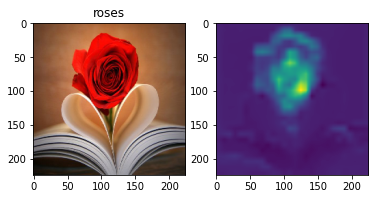

In [30]:
#Plot the original image and heatmap.
#The highlighted portion in the heatmap contributed towards the classified label

plt.subplot(1,2,1)
plt.title(classes[predicted_label])
plt.imshow(test_img_arr[0])

plt.subplot(1,2,2)
heatmap = heatmap/255
plt.imshow(heatmap)

plt.show()